# Unique quality assessment title (to be finalised by C3S), including [data stream]-[quality area]-for-[application area]

Production date: 24-05-2024

## Use case: Assess the impact of climate change on Alpine ski resorts

## Quality assessment questions

* **Can I use CERRA to describe local climatology in snow cover over mountain regions in Europe?**
* **How does CERRA represent local trends in snow-cover over mountain regions?**

This note presents an evaluation of the snow depth climatology within the CERRA reanalysis. Our focus is on the Alps, where the effects of global warming are expected to manifest themselves in contrasting ways. For example, the interplay between the rising of the zero-degree altitude and increased winter precipitation has led to glacier expansion even under warming conditions in some regions [[1]](https://doi.org/10.1002/joc.1500).

One noteworthy aspect of CERRA is its utilization of a layered model for the Earth's surface (SURFEXV8.1)[[2]](https://confluence.ecmwf.int/display/CKB/Copernicus+European+Regional+ReAnalysis+%28CERRA%29%3A+product+user+guide). This model incorporates a more comprehensive representation of surface topography and physiographic data, which is expected to enhance the accuracy of information concerning soli humidity, temperature and snow cover.

## Quality assessment statement

```{admonition} These are the key outcomes of this assessment
:class: note
* CERRA offers geographically detailed, high-resolution snow depth data that encompasses key topographic features, including challenging terrains like the Alps.
* The snow-depth long-term trend derived from CERRA appears to partially contradict observational studies conducted in the same regions. As a result, it is crucial to approach the long-term patterns from this dataset with caution.
* The timeframe between 1985 and 2020, which is encompassed by CERRA, limits the feasibility of conducting systematic studies on the detection of the impact of climate change on snow cover.
```

## Methodology

The analysis focuses on snow depth data over the Alps during the period 1986-2020. The analysis and results are organized in the following steps, which are setailed in the sections below:

1. [Choose the data to use and setup the code](#id1)
    * Import required packages
    * Define data request
2. [Datasets retrieval and computation of trends](#id2)
    * Define functions
    * Datasets retrieval
3. [Plot and describe results](#id3)
    * Display results
    * Discussion 

## Analysis and results


### 1. Choose the data to use and setup the code
<a id="id1"></a>
#### Import required packages

Besides the standard libraries `xarray` for the handling of datasets and `matplotlib` for the graphical outputs, `cartopy` is necessary for the map projection functions. One of the `utils` included in the package `c3s_eqc_automatic_quality_control` is used to crop CERRA data over the area of interest. In fact, differently from ERA5, the reanalysis CERRA does not allow the extraction of areal subsets on retrieval. We also use the package `tempfile` to handle temporary files for the computation of the trend.

In [6]:
import tempfile
import cartopy.crs as ccrs
import matplotlib.pyplot as plt
import xarray as xr
from c3s_eqc_automatic_quality_control import diagnostics, download, plot, utils
from cartopy.mpl.gridliner import Gridliner

plt.style.use("seaborn-v0_8-notebook")

#### Define data request
Our analysis is specifically centered around snow-depth data, focusing on a relatively small area within the Alps. This choice allows us to emphasize the performance of CERRA in regions characterized by a complex topography, as well as where snow depth data are critical for many sectoral impact studies, from energy to agriculture and tourism, including water supply for industry and civil use. However, different regions (e.g., Scandinavia) can be selected and analysed.

Note that variable names should be handled carefully, as the names used in the CDS data retrieval panel, which are meant to be human-readable, differ from the variable names adopted in the GRIB and NetCDF files.

In [2]:
# Region of interest
region = {
    "Alps" : { "lonmin"   : 5, "lonmax"  : 15, "latmin"  : 43, "latmax"  : 48 },
    "Scandinavia" : { "lonmin"   : 10, "lonmax"  : 42, "latmin"  : 62, "latmax"  : 72 },
}
of_interest = "Alps"
roi = region[of_interest]
lon_slice = slice(roi["lonmin"], roi["lonmax"])
lat_slice = slice(roi["latmin"], roi["latmax"])

# Time period
start = "1986-01"
stop = "2020-12"

# Variable names
varname_cds = "snow_depth"
varname_grb = "sde"

# Define data request
collection_id = "reanalysis-cerra-single-levels"
request = {
    "level_type": "surface_or_atmosphere",
    "variable": varname_cds,
    'data_type': 'reanalysis',
    'product_type': 'analysis',
    "time": "00:00",
    "format": "grib",
}
requests = download.update_request_date(request, start=start, stop=stop, stringify_dates=True)

### 2. Datasets retrieval and computation of trend
<a id='id2'></a>
#### Define functions
The analysis uses the `compute_time_mean_and_linear_trend` function to calculate the time mean and linear trend of the snow depth, and the `compute_spatial_weighted_mean_and_std` function to compute its spatial weighted mean and associated standard deviation time series. 

In [3]:
def get_da(ds):
    (varname,) = ds.data_vars
    return ds[varname]

def rechunk(da, target_store):
    da = da.chunk("auto").unify_chunks()
    da.to_zarr(target_store)
    ds = xr.open_dataset(target_store, chunks=dict(da.chunksizes), engine="zarr")
    return ds.set_coords(da.coords)[da.name]

def compute_time_mean_and_linear_trend(ds, lon_slice=lon_slice, lat_slice=lat_slice):
    # Crop area of interest
    ds = utils.regionalise(ds, lon_slice=lon_slice, lat_slice=lat_slice)
    da = get_da(ds)
    with tempfile.TemporaryDirectory() as tmpdir:
        print(f"{tmpdir=}")
        da = rechunk(da, f"{tmpdir}/target.zarr")
        datarrays = []
        for reduction in ("mean", "linear_trend"):
            print(f"{reduction=}")
            func = getattr(diagnostics, f"time_weighted_{reduction}")
            datarrays.append(func(da, weights=False).rename(reduction))
        return xr.merge(datarrays).compute()

def compute_spatial_weighted_mean_and_std(ds, lon_slice=lon_slice, lat_slice=lat_slice):
    # Crop area of interest
    ds = utils.regionalise(ds, lon_slice=lon_slice, lat_slice=lat_slice)
    da = get_da(ds)
    datarrays = []
    for reduction in ("mean", "std"):
        func = getattr(diagnostics, f"spatial_weighted_{reduction}")
        datarrays.append(func(da, weights=True).rename(reduction))
    return xr.merge(datarrays)

#### Datasets retrieval and processing 

In [4]:
# Time mean and linear trend of snow depth
ds_maps = download.download_and_transform(
    collection_id,
    requests,
    transform_func=compute_time_mean_and_linear_trend,
    transform_func_kwargs={
        "lon_slice": lon_slice,
        "lat_slice": lat_slice,
    },
    transform_chunks=False,
    chunks={"year": 1},
)

# Spatial weighted mean and standard deviation of snow depth
ds_timeseries = download.download_and_transform(
    collection_id,
    requests,
    transform_func=compute_spatial_weighted_mean_and_std,
    transform_func_kwargs={
        "lon_slice": lon_slice,
        "lat_slice": lat_slice,
    },
    chunks={"year": 1},
)

100%|██████████| 35/35 [00:04<00:00,  7.20it/s]


### 3. Plot and describe results
<a id='id3'></a>
#### Display results
Maps of the snow depth climatology and of the corresponding trend are shown below. The unit of the linear trend is converted into meters per decade. The time series of the average snow cover over the entire region is also reported, along with the corresponding standard deviation among all grid points in the region of interest. 

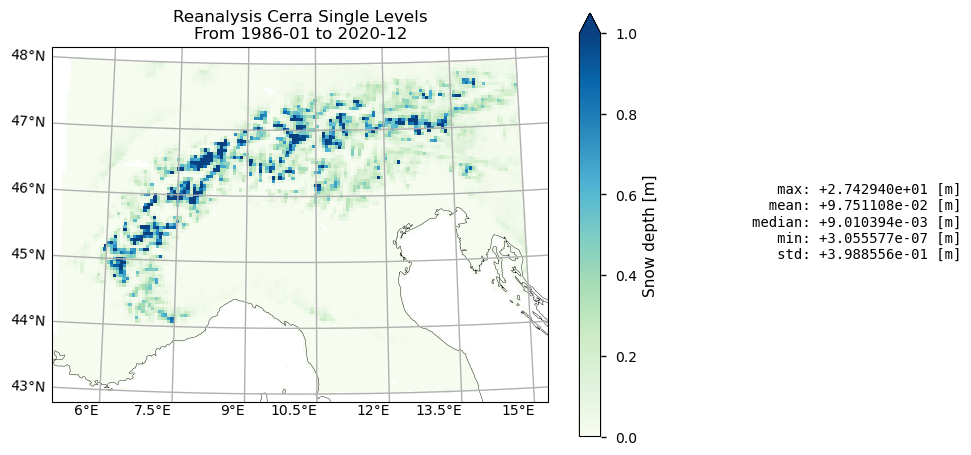

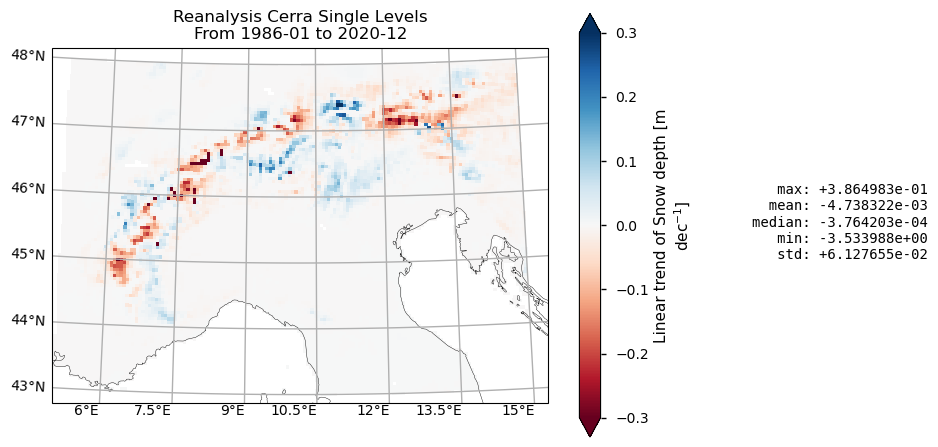

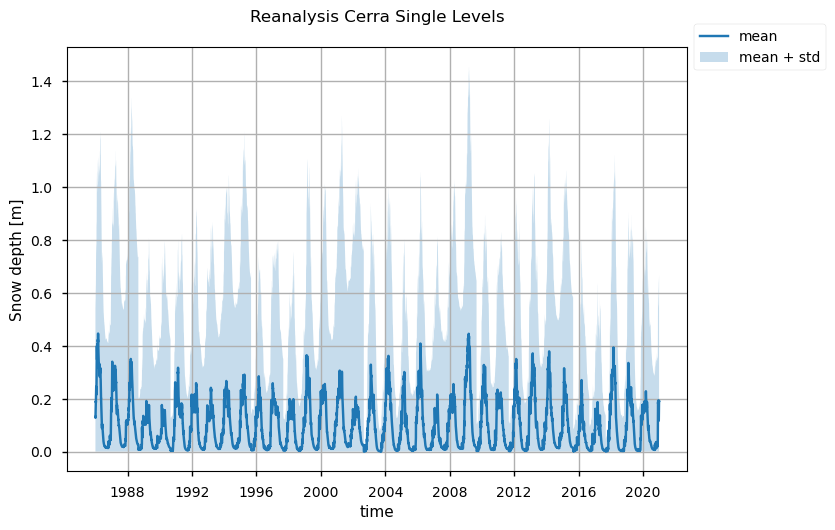

In [7]:
# Climatological map of snow depth
projection = ccrs.LambertConformal(
    central_longitude=ds_maps["longitude"].mean().values,
    central_latitude=ds_maps["latitude"].mean().values,
)
plot_obj = plot.projected_map(ds_maps["mean"],vmin=0,vmax=1,cmap="GnBu",projection=projection)
gridliners = [a for a in plot_obj.axes.artists if isinstance(a, Gridliner)]
for gl in gridliners:
    gl.x_inline = False
    gl.xlabel_style = {"rotation": 0}
#for gl in plot_obj.axes._gridliners:
#        gl.x_inline = False
#        gl.xlabel_style = {"rotation": 0}
plt.title(f"{collection_id.replace('-', ' ').title()}\nFrom {start} to {stop}")
plt.show()

# Linear trend map of snow depth
ds_maps["Linear trend of Snow depth [m dec$^{-1}$]"]=ds_maps["linear_trend"]
plot_obj = plot.projected_map(ds_maps["Linear trend of Snow depth [m dec$^{-1}$]"]*10*365*86400,vmin=-0.3,vmax=0.3,cmap="RdBu",projection=projection, label='test')
gridliners = [a for a in plot_obj.axes.artists if isinstance(a, Gridliner)]
for gl in gridliners:
    gl.x_inline = False
    gl.xlabel_style = {"rotation": 0}

#for gl in plot_obj.axes._gridliners:
#        gl.x_inline = False
#        gl.xlabel_style = {"rotation": 0}
plt.title(f"{collection_id.replace('-', ' ').title()}\nFrom {start} to {stop}")
plt.show()

# Interannual variability time series of snow depth
fig, ax = plt.subplots()
ds_timeseries["mean"].plot(ax=ax, label="mean")
ax.fill_between(
    ds_timeseries["time"],
    ds_timeseries["mean"] - ds_timeseries["mean"],
    ds_timeseries["mean"] + ds_timeseries["std"],
    alpha=0.25,
    label="mean + std",
)
plt.xlabel('time')
ax.grid()
ax.legend(loc="center left", bbox_to_anchor=(1, 1))
_ = ax.set_title(
    f"{collection_id}\n".replace("-", " ").replace("_", " ").title()
)

#### Discussion

* ***Climatology of snow depth***

The climatological map of snow depth (see below) reveals a wealth of geographic details, which correspond to the complex terrain of the area. The mean value reported in the statistic, displayed in the map's legend, appears to be quite low (a few centimeters). This is due to the region being largely snow-free for most of the year. However, it is worth noting that there are significant snow depth observed, with the highest recorded value reaching nearly 30 meters. This extreme value is found in the western Italian Alps, specifically over Mont Blanc (Monte Bianco).

* ***Linear trend of snow depth*** 

The linear trend map of snow depth (see below) shows a mixed pattern of positive and negative trends in different areas over the Alps, which is in line with results presented in previous studies [[3]](https://doi.org/10.3390/environsciproc2023026016). In general, the negative trend seems mostly concentrated over mountains areas of higher elevations. This results is in contrast with the findings of Matiu et al. (2021) [[4]](https://doi.org/10.5194/tc-15-1343-2021), who have analyzed a comprehensive data set of *in situ* observations, suggesting an overall negative trend at low altitudes (below 1000 m) and a potential, but not always, positive trend at higher altitudes (over 2000 m). Although a detailed spatial analysis of snow depth is not provided by Matiu et al. (2021), this assessment shows that snow depth data from reanalysis datasets such CERRA should be evaluated carefully, at least in this specific area. This finding confirms what already suggested by Monteiro and Morin (2023) [[5]](https://doi.org/10.5194/tc-17-3617-2023), who attributed discrepancies between reanalysis and observed snow depths to different factors, such as the misrepresentation of wind-transport and glacier accumulation, among others.

* ***Interannual variability of snow depth***

The time series of the mean snow depth over the Alps and the corresponding standard deviation are shown below. As expected from the previous analysis, the mean snow depth doesn't exhibit any clear trend over the long term. Instead, we observe a significant snow depth variability, with particularly high values in 2009 when exceptional snow events have been recorded in the area.

## If you want to know more
#### Key resources
* CDS catalogue entries used in this notebook is [CERRA sub-daily regional reanalysis data for Europe on single levels from 1984 to present](https://cds.climate.copernicus.eu/cdsapp#!/dataset/reanalysis-cerra-single-levels?tab=overview)
* Product Documentation for [CERRA](https://cds.climate.copernicus.eu/cdsapp#!/dataset/reanalysis-cerra-single-levels?tab=doc) is available

<a id='idBOpen'></a>
Code libraries used:
* [C3S EQC custom functions](https://github.com/bopen/c3s-eqc-automatic-quality-control/tree/main/c3s_eqc_automatic_quality_control), `c3s_eqc_automatic_quality_control`, prepared by [BOpen](https://www.bopen.eu/)

#### References

[[1]](https://doi.org/10.1002/joc.1500) Calmanti, S., Motta, L., Turco, M., & Provenzale, A. (2007). Impact of climate variability on Alpine glaciers in northwestern Italy. International Journal of Climatology: A Journal of the Royal Meteorological Society, 27(15), 2041-2053.

[[2]](https://confluence.ecmwf.int/display/CKB/Copernicus+European+Regional+ReAnalysis+%28CERRA%29%3A+product+user+guide) Schimanke, S., Isaksson, L., & Edvinsson, L. (2022). Copernicus European Regional ReAnalysis (CERRA): product user guide.

[[3]](https://doi.org/10.3390/environsciproc2023026016) Masloumidis, I., Dafis, S., Kyros, G., & Lagouvardos, K. (2023). Snow depth Trends of European Ski Resorts. Environmental Sciences Proceedings, 26, 16.

[[4]](https://doi.org/10.5194/tc-15-1343-2021) Matiu, M., Crespi, A., Bertoldi, G., Carmagnola, C. M., Marty, C., Morin, S., ... & Weilguni, V. (2020). Observed snow depth trends in the European Alps 1971 to 2019. The Cryosphere Discussions, 2020, 1-50.

[[5]](https://doi.org/10.5194/tc-17-3617-2023) Monteiro, D., & Morin, S. (2023). Multi-decadal analysis of the past winter temperature, precipitation and snow cover data in the European Alps from reanalyses, climate models and observational datasets. The Cryosphere, 17, 3617-3660.